## Trapezoidal virtual analog first order filters.

HTML output built with: jupyter nbconvert --to html va_one_pole.ipynb

http://www.willpirkle.com/Downloads/AN-4VirtualAnalogFilters.pdf

In [1]:
from math import *
import cmath
import matplotlib.pyplot as plt

In [2]:
def db_from_lin(gain):
    return log(gain, 10.0) * 20.0

def lin_from_db(decibels):
    return pow(10.0, decibels * 0.05)

In [3]:
def va_bode_digital(f_hz, coeffs, fs):
    #WIP, not fully correct yet
    a, g, a1, m0, m1 = coeffs

    z = cmath.exp(-(2 * pi) * f_hz * 1j / fs)
    
    denominator = 1 + (-1 + 2 * g) * z

    y = m0 + (m1 * g * (1 + z)) / denominator

    return y


In [4]:
def plot_svf(svf_coeffs):
    amplitude = []
    phase = []
    x = []
    for i in range(20, 22000, 10):
        n = va_bode_digital(i, svf_coeffs, 44100)
        amplitude.append(db_from_lin(abs(n).real))
        phase.append(degrees(cmath.phase(n)))
        x.append(i)

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.semilogx(x, amplitude)
    ax1.set_ylabel("amplitude")
    ax1.set_ylim([-12, 12])

    ax2 = ax1.twinx()
    ax2.semilogx(x, phase, "r-")
    ax2.set_ylabel("phase", color="r") 
    ax2.set_ylim([-180, 180])
    
    plt.xlim([20, 24000])
    plt.show()

In [5]:
def lowpass(f0, fs):
    a = 1.0
    g = tan(pi * f0 / fs)
    a1 = g / (1.0 + g)
    m0 = 0.0
    m2 = 1.0
    return a, g, a1, m0, m2

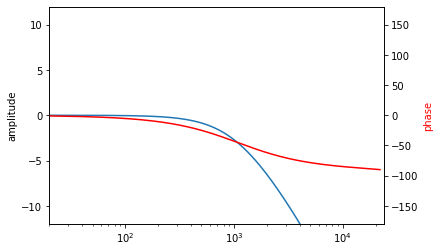

In [6]:
svf_coeffs = plot_svf(lowpass(1000, 44100))

In [7]:
def highpass(f0, fs):
    a = 1.0
    g = tan(pi * f0 / fs)
    a1 = g / (1.0 + g)
    m0 = 1.0
    m2 = -1.0
    return a, g, a1, m0, m2

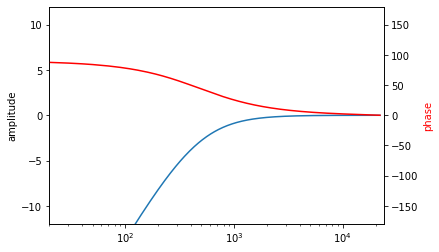

In [8]:
svf_coeffs = plot_svf(highpass(1000, 96000))

In [9]:
def allpass(f0, fs):
    a = 1
    g = tan(pi * f0 / fs)
    a1 = g / (1.0 + g)
    m0 = 1.0
    m2 = -2.0
    return a, g, a1, m0, m2

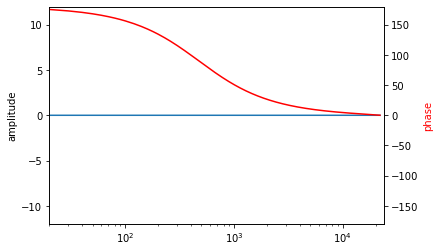

In [10]:
svf_coeffs = plot_svf(allpass(1000, 96000))

In [11]:
def lowshelf(f0, db_gain, fs):
    a = pow(10, db_gain / 20.0)
    g = tan(pi * f0 / fs) / sqrt(a)
    a1 = g / (1.0 + g)
    m0 = 1.0
    m2 = a - 1.0
    return a, g, a1, m0, m2

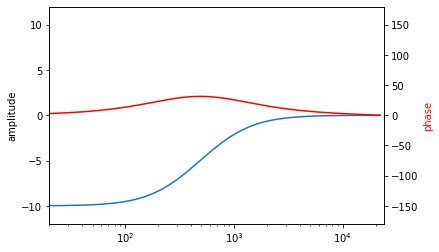

In [12]:
svf_coeffs = plot_svf(lowshelf(1000, -10, 96000))

In [13]:
def highshelf(f0, db_gain, fs):
    a = pow(10, db_gain / 20.0)
    g = tan(pi * f0 / fs) * sqrt(a)
    a1 = g / (1.0 + g)
    m0 = a
    m2 = 1.0 - a
    return a, g, a1, m0, m2

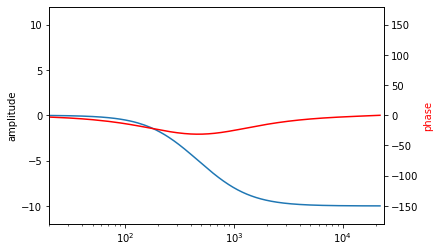

In [14]:
svf_coeffs = plot_svf(highshelf(1000, -10, 96000))


In [15]:
class Filter(object):
    def __init__(self, coeffs):
        super().__init__()
        self.coeffs = coeffs
        self.ic1eq = 0.0

    def process(self, x):
        a, g, a1, m0, m1 = self.coeffs
        v1 = a1 * (x - self.ic1eq)
        v2 = v1 + self.ic1eq
        self.ic1eq = v2 + v1
        return m0 * x + m1 * v2